In [32]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
from torch.optim import lr_scheduler
import argparse

In [22]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [23]:
cd /content/drive/MyDrive/ProjectB

/content/drive/MyDrive/ProjectB


In [24]:
from networks import MLP, ConvNet, LeNet, AlexNet, AlexNetBN, VGG11, VGG11BN, ResNet18, ResNet18BN_AP, ResNet18BN
from utils import get_loops, get_dataset, get_network, get_eval_pool, evaluate_synset, get_daparam, match_loss, get_time, TensorDataset, epoch, DiffAugment, ParamDiffAug

# Dataset Preparation (MNIST)

In [25]:
mean = [0.1307]
std = [0.3081]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=mean, std=std)])

In [26]:
data_train = datasets.MNIST(root = "./data/",
               transform=transform,
               train = True,
               download = True)

data_test = datasets.MNIST(root="./data/",
               transform = transform,
               train = False)

In [27]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                         batch_size = 128,
                         shuffle = True,
                         num_workers=2)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                         batch_size = 128,
                         shuffle = True,
                         num_workers=2)

In [28]:
print(len(data_train))

60000


[tensor(9), tensor(2), tensor(0), tensor(0), tensor(8), tensor(6), tensor(3), tensor(2), tensor(2), tensor(1), tensor(7), tensor(8), tensor(0), tensor(4), tensor(2), tensor(2), tensor(1), tensor(9), tensor(4), tensor(1), tensor(7), tensor(5), tensor(0), tensor(8), tensor(9), tensor(3), tensor(9), tensor(1), tensor(1), tensor(4), tensor(8), tensor(2), tensor(4), tensor(7), tensor(3), tensor(0), tensor(4), tensor(8), tensor(1), tensor(0), tensor(7), tensor(9), tensor(4), tensor(3), tensor(7), tensor(1), tensor(9), tensor(3), tensor(1), tensor(3), tensor(0), tensor(2), tensor(4), tensor(9), tensor(5), tensor(2), tensor(3), tensor(7), tensor(3), tensor(5), tensor(8), tensor(2), tensor(6), tensor(4)]


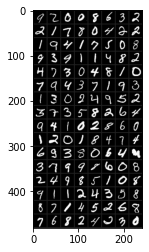

In [29]:
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

# Load Network (ConvNet)

In [41]:
net = get_network('ConvNet', 1 , num_classes = 10, im_size=(32, 32))
net = net.to('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
criterion = nn.CrossEntropyLoss()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(),lr=0.01)  # optimizer_img for synthetic data
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_net,20)
num_epochs = 20

In [43]:
for epoch in range(num_epochs):
  net.train(True) # Train mode 
  loss_tot = 0.0
  correct_tot = 0
  print("Epoch {}/{}".format(epoch, num_epochs))
  print("-"*10)
  for data in data_loader_train:
    imgs, labels = data
    imgs = imgs.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer_net.zero_grad() # clear the grad
    outputs = net(imgs) # forward
    loss = criterion(outputs,labels) # loss calculation
    pred = torch.argmax(outputs,dim=1)
    loss_tot += loss.data
    correct_tot += torch.sum(pred == labels.data)
    loss.backward()
    optimizer_net.step()
    scheduler.step()
    
  net.train(False)
  testing_correct = 0
  for data in data_loader_test:
    img_test, label_test = data
    img_test = img_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    label_test = label_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = net(img_test)
    pred = torch.argmax(outputs,dim=1)
    testing_correct += torch.sum(pred == label_test.data)
  print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(loss_tot/len(data_train),
                                           100*correct_tot/len(data_train),
                                           100*testing_correct/len(data_test)))


Epoch 0/20
----------
Loss is:0.0043, Train Accuracy is:90.5800%, Test Accuracy is:96.3600
Epoch 1/20
----------
Loss is:0.0012, Train Accuracy is:96.7450%, Test Accuracy is:97.5900
Epoch 2/20
----------
Loss is:0.0008, Train Accuracy is:97.5317%, Test Accuracy is:97.6100
Epoch 3/20
----------
Loss is:0.0007, Train Accuracy is:98.0100%, Test Accuracy is:98.0500
Epoch 4/20
----------
Loss is:0.0006, Train Accuracy is:98.2567%, Test Accuracy is:98.5100
Epoch 5/20
----------
Loss is:0.0005, Train Accuracy is:98.4567%, Test Accuracy is:98.6900
Epoch 6/20
----------
Loss is:0.0004, Train Accuracy is:98.5617%, Test Accuracy is:98.7300
Epoch 7/20
----------
Loss is:0.0004, Train Accuracy is:98.6583%, Test Accuracy is:98.8300
Epoch 8/20
----------
Loss is:0.0004, Train Accuracy is:98.7567%, Test Accuracy is:98.9700
Epoch 9/20
----------
Loss is:0.0004, Train Accuracy is:98.8717%, Test Accuracy is:98.9500
Epoch 10/20
----------
Loss is:0.0003, Train Accuracy is:98.9050%, Test Accuracy is:98.950

# Data Preparation (CIFAR10)

In [44]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=mean, std=std)])

In [45]:
data_train = datasets.CIFAR10(root = "./data/",
               transform=transform,
               train = True,
               download = True)

data_test = datasets.CIFAR10(root="./data/",
               transform = transform,
               train = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/


In [46]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                         batch_size = 128,
                         shuffle = True,
                         num_workers=2)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                         batch_size = 128,
                         shuffle = True,
                         num_workers=2)

[tensor(0), tensor(7), tensor(6), tensor(0), tensor(0), tensor(7), tensor(5), tensor(5), tensor(8), tensor(5), tensor(9), tensor(8), tensor(7), tensor(6), tensor(7), tensor(5), tensor(9), tensor(0), tensor(2), tensor(0), tensor(7), tensor(7), tensor(0), tensor(1), tensor(9), tensor(3), tensor(5), tensor(0), tensor(7), tensor(7), tensor(3), tensor(4), tensor(2), tensor(1), tensor(3), tensor(7), tensor(0), tensor(0), tensor(7), tensor(8), tensor(8), tensor(5), tensor(7), tensor(7), tensor(3), tensor(7), tensor(9), tensor(9), tensor(1), tensor(4), tensor(5), tensor(9), tensor(9), tensor(6), tensor(1), tensor(7), tensor(4), tensor(2), tensor(0), tensor(3), tensor(0), tensor(4), tensor(3), tensor(2)]


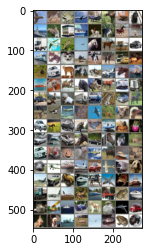

In [47]:
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
img = img*std+mean
print([labels[i] for i in range(64)])
plt.imshow(img)

# Load Network (ConvNet)

In [129]:
net = get_network('ConvNet', 3 , num_classes = 100, im_size=(32, 32))
net = net.to('cuda' if torch.cuda.is_available() else 'cpu')

In [130]:
criterion = nn.CrossEntropyLoss()
net_parameters = list(net.parameters())
optimizer_net = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.9)  # optimizer_img for synthetic data
scheduler = lr_scheduler.CosineAnnealingLR(optimizer_net,20)
num_epochs = 20

In [131]:
for epoch in range(num_epochs):
  net.train(True) # Train mode 
  loss_tot = 0.0
  correct_tot = 0
  print("Epoch {}/{}".format(epoch, num_epochs))
  print("-"*10)
  for data in data_loader_train:
    imgs, labels = data
    imgs = imgs.to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = labels.to('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer_net.zero_grad() # clear the grad
    outputs = net(imgs) # forward
    loss = criterion(outputs,labels) # loss calculation
    pred = torch.argmax(outputs,dim=1)
    loss_tot += loss.data
    correct_tot += torch.sum(pred == labels.data)
    loss.backward()
    optimizer_net.step()
  scheduler.step()
    
  net.train(False)
  testing_correct = 0
  for data in data_loader_test:
    img_test, label_test = data
    img_test = img_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    label_test = label_test.to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = net(img_test)
    pred = torch.argmax(outputs,dim=1)
    testing_correct += torch.sum(pred == label_test.data)
  print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(loss_tot/len(data_train),
                                           100*correct_tot/len(data_train),
                                           100*testing_correct/len(data_test)))


Epoch 0/20
----------
Loss is:0.0106, Train Accuracy is:52.8240%, Test Accuracy is:62.8200
Epoch 1/20
----------
Loss is:0.0073, Train Accuracy is:67.5560%, Test Accuracy is:68.8300
Epoch 2/20
----------
Loss is:0.0060, Train Accuracy is:73.4780%, Test Accuracy is:72.2800
Epoch 3/20
----------
Loss is:0.0052, Train Accuracy is:77.3300%, Test Accuracy is:73.2600
Epoch 4/20
----------
Loss is:0.0046, Train Accuracy is:79.8400%, Test Accuracy is:74.6500
Epoch 5/20
----------
Loss is:0.0041, Train Accuracy is:82.2520%, Test Accuracy is:77.1900
Epoch 6/20
----------
Loss is:0.0037, Train Accuracy is:84.2620%, Test Accuracy is:77.2800
Epoch 7/20
----------
Loss is:0.0032, Train Accuracy is:86.3020%, Test Accuracy is:78.0200
Epoch 8/20
----------
Loss is:0.0028, Train Accuracy is:88.0100%, Test Accuracy is:77.9000
Epoch 9/20
----------
Loss is:0.0025, Train Accuracy is:89.8460%, Test Accuracy is:78.9300
Epoch 10/20
----------
Loss is:0.0021, Train Accuracy is:91.6500%, Test Accuracy is:79.320